## Car Accident Severity

### Introduction/Business Problem

Every year there are approximately 6 million car accidents in the US alone.  Car accidents are cause of the thousands of deaths and billions of dollars in expenses according to the US Car Accident statistics.
Analyzing the accident data in a major city like Seattle, may offer insights on car accidents in other major cities as well.
Goal is to understand this data to predict what factors lead to severity of accidents such as location, weather conditions, collision type etc.  Are there any factors we can educate the public to reduce the number of accidents.  Also, if find strong co-relation with certain weather conditions and severity of accidents, it may help to warn the drivers when faced with sthis situations.  This information can also be used to decide policies e.g. speed limit, closure of roads due to certain conditions etc.  Car insurance companies will also be interested to learn the insights from this data.  


### Data

Dataset is Seattle city collision data provided by the Seattle Police Department and recorded by Traffic Records.  It consists  ~194673 instances of collisions and ~38 attributes describing the event - severity of the accident, location, weather, collision type etc.  Collisions will be displayed at the intersection or mid-block of a segment. Timeframe of the data is 2004 to Present, thus it includes over 15 years of data that will help to see the trend over a decade.

This data will be explored to find what features most relevant to predict the severity of the accident.
 
Meta data to understand the attributes: https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf

For example: SEVERITYCODE: A code that corresponds to the severity of the collision.

    3—fatality
    2b—serious injury
    2—injury
    1—prop damage
    0—unknown 
    
For purpose of this analysis when SEVERITYCODE is 2, that's severe collision and when it's 1, it's not as severe.  Goal is to predict based on the given features.

#### Data Cleaning

Dataset has 194673 rows and 38 columns. However, not all columns are relevant.  So first created subset using only relevant columns:

    SEVERITYCODE, ADDRTYPE, COLLISIONTYPE, PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT, JUNCTIONTYPE, INATTENTIONIND, WEATHER, 
    ROADCOND, LIGHTCOND, UNDERINFL,SPEEDING,HITPARKEDCAR.
    
Some of the cleaning steps were: 

    (1) Remove rows when Junctiontype, Weather, Reoad Condition or Light Condition is 'Unknown'.
    
    (2) INATTENTIONIND, SPEEDING while driving when Not available, set to 'No' as that seems logical option.
    
    (3) INATTENTIONIND, SPEEDING, HITPARKEDCAR, UNDERINFL had mixed values Y, N, 1, 0.  
        'Y' was converted to 1 and 'N' to 0.
    
    (4) Remove rows with NaN for ADDRTYPE, COLLISIONTYPE, WEATHER, LIGHTCOND, ROADCOND.  
        Also while convering categorical values to numeric if column containts 'Other' it was removed.
        
    (5) ADDRTYPE, COLLISIONTYPE, WEATHER, LIGHTCOND, ROADCOND - categorical variables were converted numerical values using
        encoding. 
    
Removing this does introduce bias in data sampling, but there is no way around that problem in the scope of this assignment.

### Methodology

#### Exploratory Data Analysis

In [4]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt

filename = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df = pd.read_csv(filename)
df.shape

(194673, 38)

In [13]:
# Examine each column and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

<AxesSubplot:>

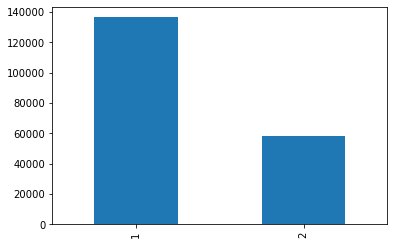

In [6]:
# 1: prop damage and 2: injury. In this context, when SEVERITYCODE =2 that's SEVERE collision.
df['SEVERITYCODE'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

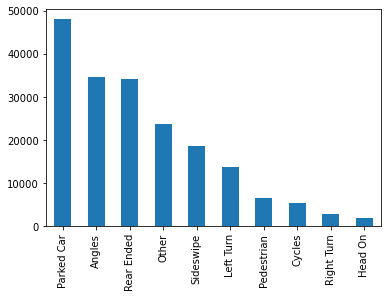

In [7]:
# Surprisingly Parked Car tops number of collisions.
df['COLLISIONTYPE'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

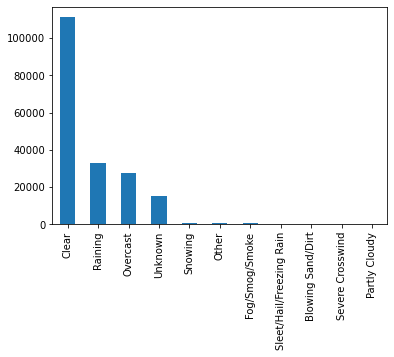

In [8]:
# Data indicates most collisions happen in Clear weather followed by Raining, Overcast.
df['WEATHER'].value_counts().plot(kind='bar')

<AxesSubplot:>

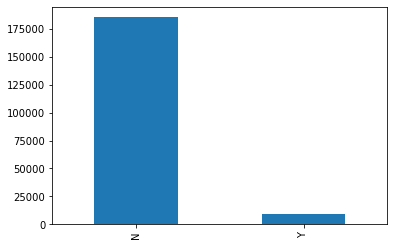

In [9]:
# Replaced NaN for SPEEDING WITH 'N', data indicates most accidents happen when not speeding
df['SPEEDING'] = df['SPEEDING'].fillna('N')
df['SPEEDING'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

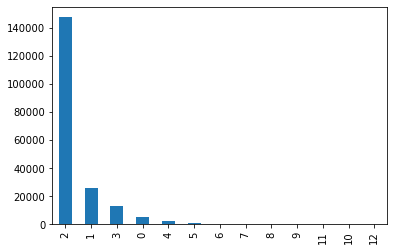

In [10]:
# Data indicates most collisions involce 2, 1 or 3 vehicles.
df['VEHCOUNT'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

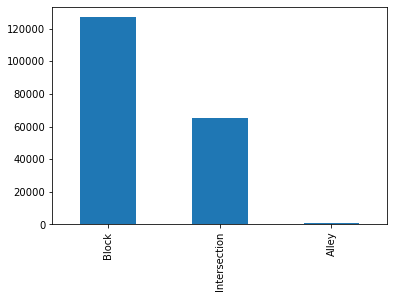

In [11]:
# Majority of collisions in Block side vs. Alley.
df['ADDRTYPE'].value_counts().plot(kind = 'bar')

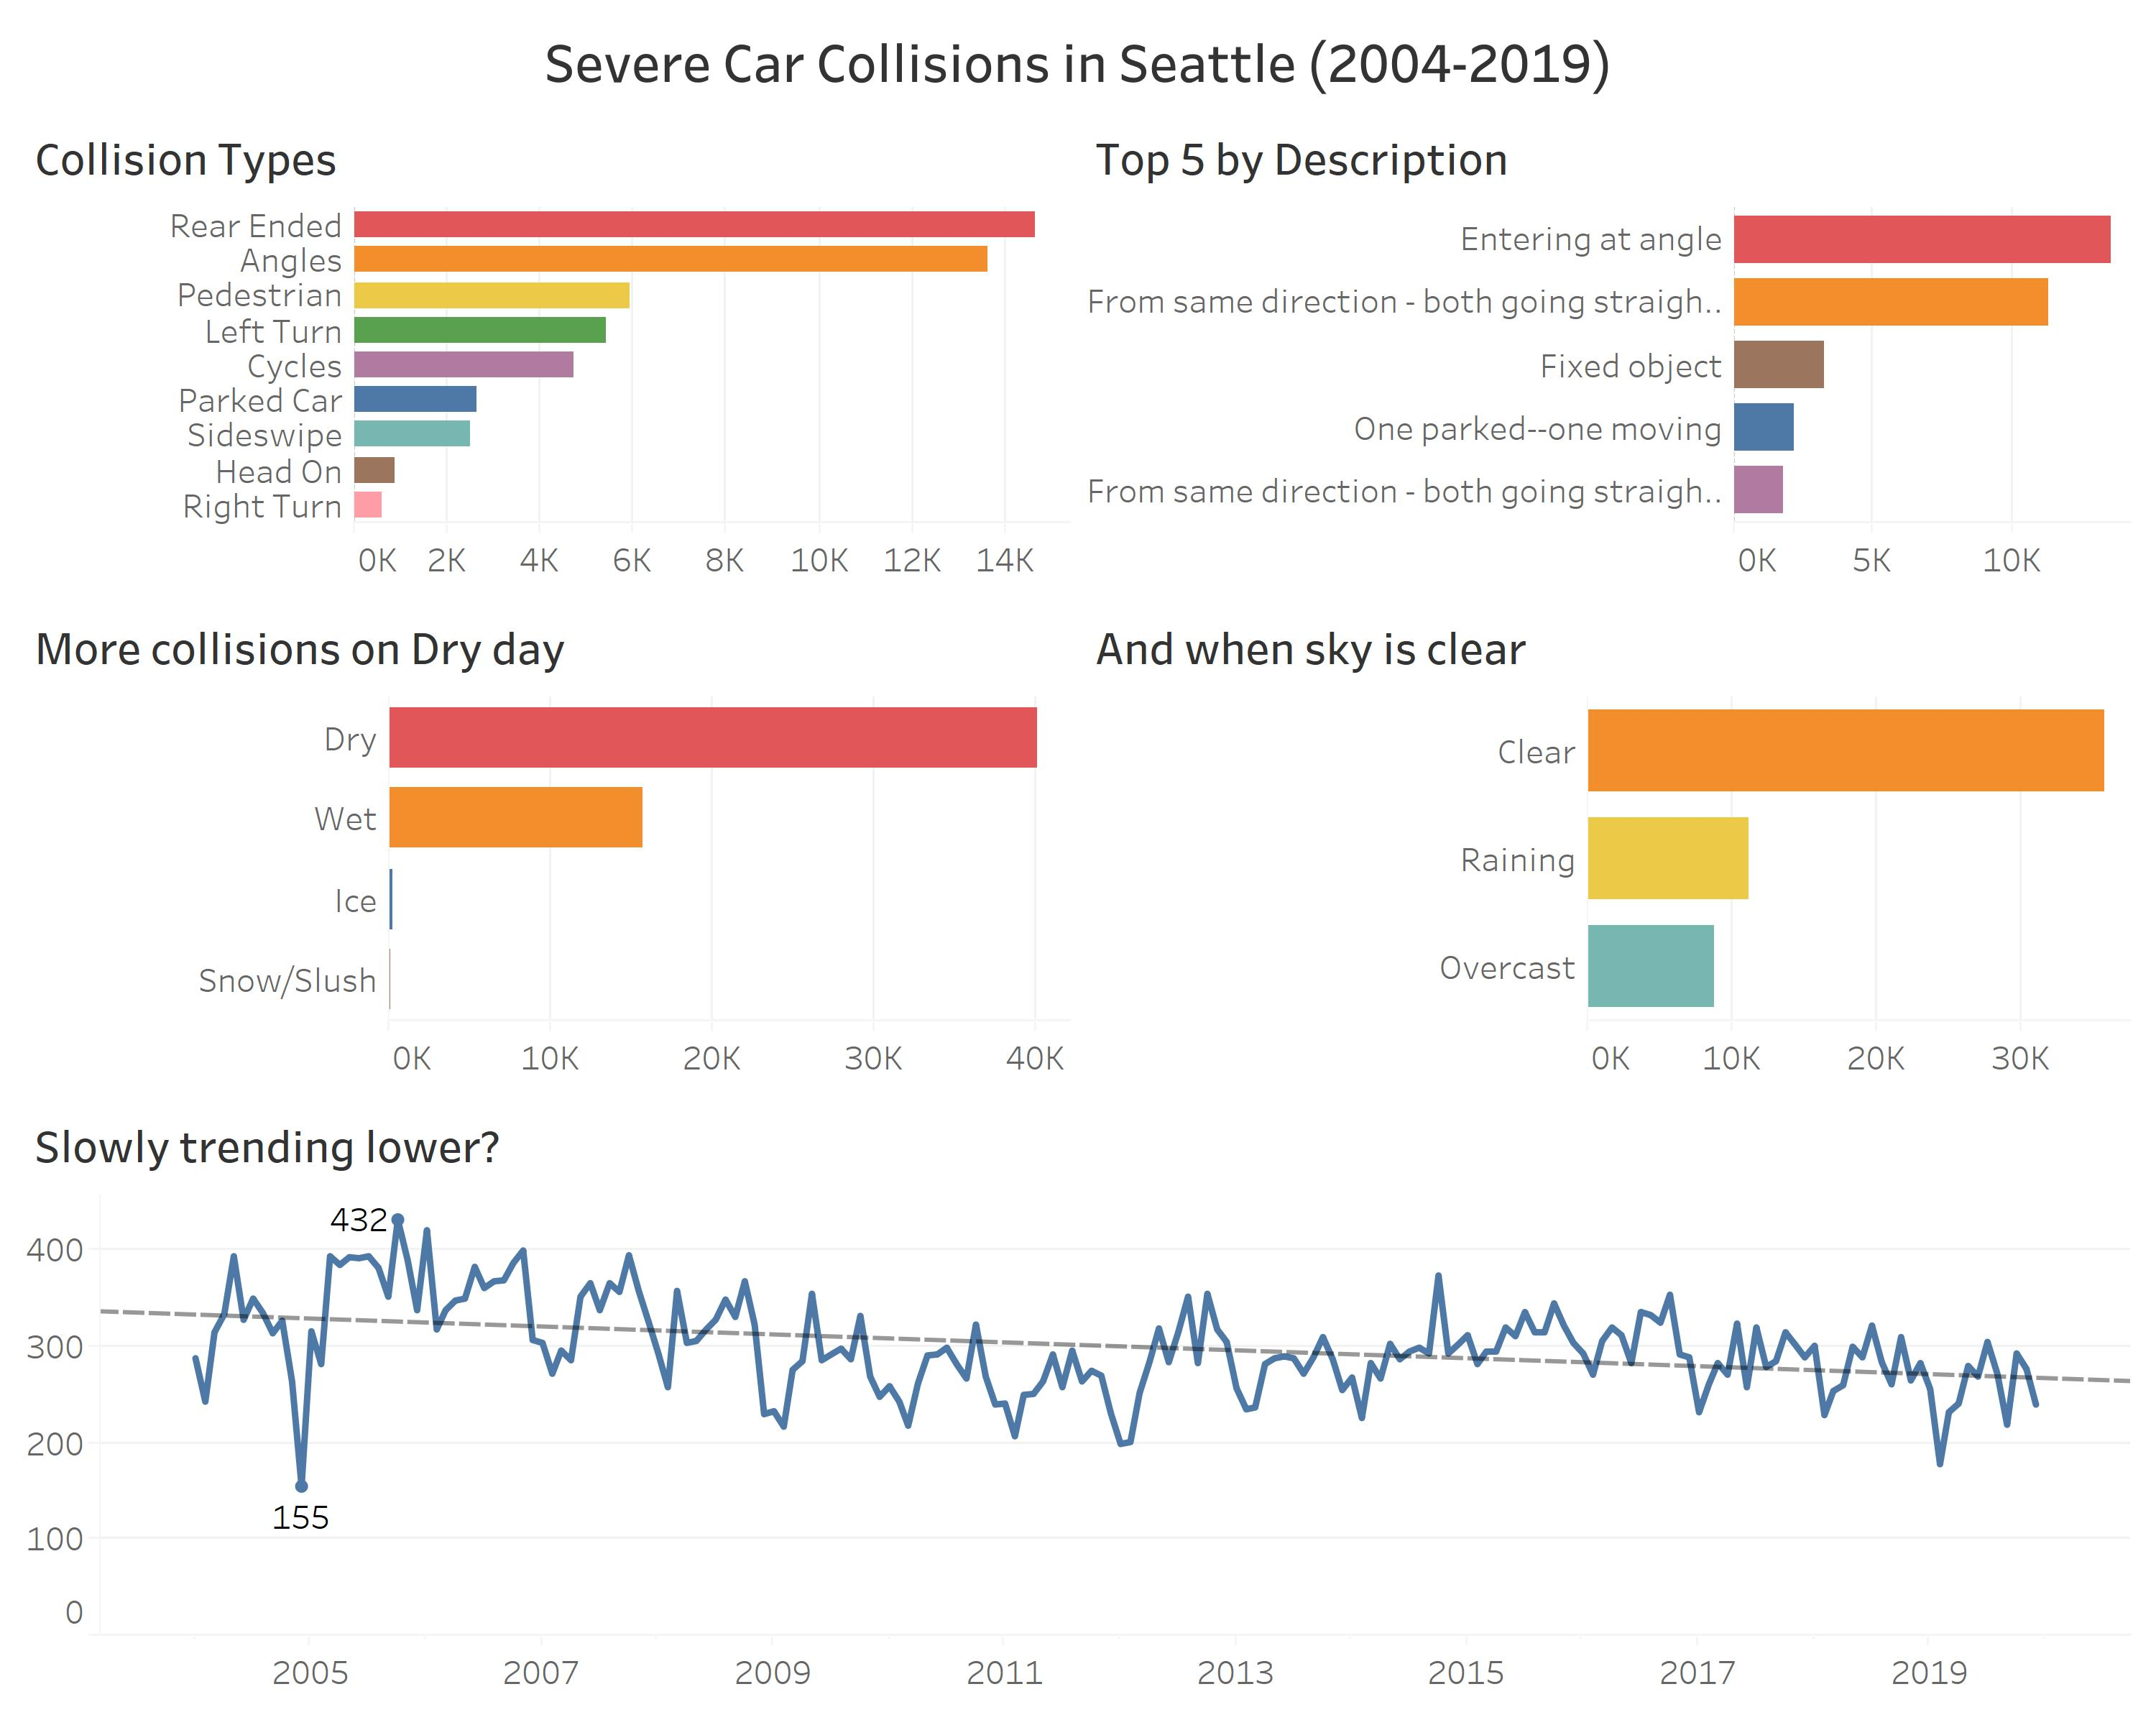

In [14]:
# Following Dashboard was created using Tableau to summarize high level severe collisions 
from IPython.display import Image
Image(filename='Seattle Severe Car Collisions.jpg') 

#### Machine Learning Models


Goal of the Machine Learning models is to predict when Collision is SEVERITY Code (1 or 2).

Thus, 
      
      SEVERITYCODE as a target (y) And
      
      Feature Matrix (X) is: 

    [ADDRTYPE, COLLISIONTYPE,WEATHER,LIGHTCOND,ROADCOND,UNDERINFL,SPEEDING,INATTENTIONIND,HITPARKEDCAR]
    
Data was split in training and test set.  Training data was used to train the model and test set for evaluating the model.

Following supervised machine learning models were used for classification:
    
   (1) Decision Tree:  
       This classification decision tree makes decision based on 'entropy' criterion (information gain at each node). Nodes of the
       tree test for the value of a certain attribute.  Edges/branches correspond to the outcome of a test and connect to next node        or leaf.  Leaf nodes are terminal nodes that predict the outcome (class label or distribution).
       That's how it determines SEVERITYCODE label 1 or 2. Following table evaluates this model.
        
                               precision    recall  f1-score   support

                       1       0.70      0.97      0.81     19422
                       2       0.76      0.19      0.30      9954

            weighted avg       0.72      0.70      0.64     29376

    
   (2) Logistic Regression: 
       This classifier finds most probable class based on given features. It predicts the probability based on logistic function.
       Following table evaluates the model.
    
                                 precision    recall  f1-score   support

                       1       0.67      0.98      0.79     19422
                       2       0.52      0.03      0.06      9954

            weighted avg       0.62      0.66      0.55     29376
    
   (3) Support Vector Machine (SVM):
       SVM works  by mapping data to a high-dimensional feature space so that data points can be categorized.
       This works even when data is not easily linearly separable, a separation between the categories is found then data is
       transformed in a way that the separator could be drawn as a hyperplane.  Mapping data into higher dimensional space is
       called kernelling.  Radial basis function (RBF) was used in kernel.
       This was very computationally intensive operation and following table shows performance, that was not any better than
       other models like Logistic Regression.
       
                             precision    recall  f1-score   support

                       1       0.69      0.91      0.78     19422
                       2       0.52      0.19      0.28      9954

            weighted avg       0.63      0.67      0.61     29376
    
    
   (4) K - Nearest Neighbors (KNN):
       KNN classifies by majority vote of k nearest neighbors.  To find the optimum k, this model was run for k being 1,2,..10.
       It was determined k = 7 gave the best accuracy.  Following table evaluates this model.
       
                             precision    recall  f1-score   support

                       1       0.73      0.86      0.79     19422
                       2       0.58      0.38      0.46      9954

            weighted avg       0.68      0.70      0.68     29376

### Results

Following table summarize how each model performed:

  | Algorithm            | Accuracy| Jaccard Index      | F1 Score|  
  |----------------------|---------|--------------------|---------|
  | Decision Tree        |  0.70   | 0.70               |   0.64  | 
  | Logistic Regression  |  0.66   | 0.66               |   0.55  | 
  | SVM                  |  0.66   | 0.66               |   0.61  | 
  | K - Nearest Neighbor |  0.70   | 0.70               |   0.68  | 

#### Discussion

Based on data exploration: 
More collisions involved property damage than severity.  Weather didn't play
as big of a role directly, because most severe collisions occured on dry day when sky was clear. 
Most severe accidents involved "read ending" and when on of the vehicle was "entering at the angle".  
Speeding also didn't play significant role for sever collisions, however, more analysis is needed to explore further.
There were several data points with Speeding 'NA' and so this missing information may introduce bias in the analysis.

Based on the quantitative analysis: 
Examining the evaluation criterion (inclusing Confusion Matrix), Decision Tree or KNN would be the best choice.
F1 Score is the harmonic average for each label based on precision adn recall - (F1 value reaches it's best at 1 and worst at 0). So it's a great way to show classifier has good value for both Precision (measure of accuaracy) and Recall (true positive rate). 
And F1 score also indicates KNN or decision tree perfomed better.

In this analysis, cost of false negative (FN) is high, because if model predicts that it's NOT SEVERE but if it's indeed SEVERE accident that would not be good, because SEVERE accident involves personal injury.

### Conclusion

None of the model gave more than 70% accuracy.  That doesn't give enough confidence to deploy these models.
One possible explanation could be, due to missing data, many data points were dropped and that will introduce bias.
More randomized data points will help for analysis. Exploratory data analysis seems more valuable over predictive analysis.

### Future Work

More randomized data is needed to train the model for gaining more confidence in predictive analysis.  There is lot of room of improvement with Feature Engineering to improve the performance of these models.  This is just very introductory analysis.